In [1]:
%load_ext autoreload
%autoreload 2


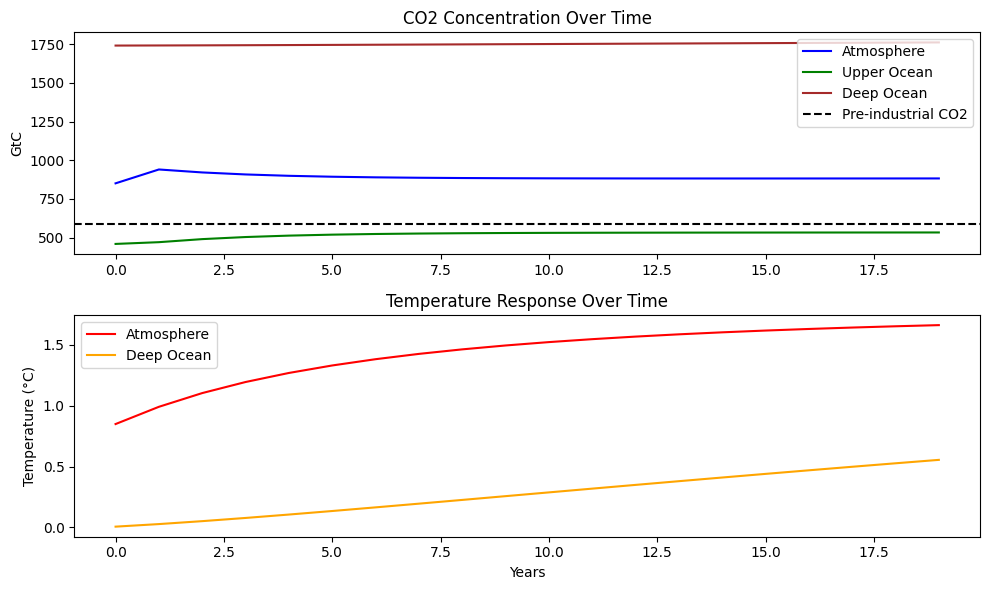

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
xPhi_T = np.array([[0.8718, 0.0088], [0.025, 0.975]])  # Climate diffusion parameters
xB_T = np.array([0.1005, 0])

xPhi_M = np.array([[0.88, 0.196, 0], [0.12, 0.797, 0.001465], [0, 0.007, 0.99853488]])  # Carbon cycle diffusion
xB_M = np.array([1.36388, 0, 0])  # 12/44

# Initial conditions (CO2 mass in different reservoirs)
xM_AT_1750 = 588  # Pre-industrial atmospheric carbon (GtC)
xM_AT_0 = 851  # Initial atmospheric carbon
xM_UP_0 = 460  # Upper ocean carbon
xM_LO_0 = 1740  # Deep ocean carbon

# Climate parameters
xF_2x = 3.6813  # Forcing at double CO2
xT_2x = 3.1  # Equilibrium temp increase at double CO2

# Initial temperature values (surface and deep ocean)
xT_AT_0 = 0.85
xT_LO_0 = 0.0068

# Simulation setup
time_steps = 20  # years
pulse_emission = 100  # GtC (CO2 pulse)

# Arrays to hold the results
M_AT = np.zeros(time_steps)
M_UP = np.zeros(time_steps)
M_LO = np.zeros(time_steps)
T_AT = np.zeros(time_steps)
T_LO = np.zeros(time_steps)

# Initial values
M_AT[0] = xM_AT_0
emission = np.zeros(time_steps)
emission[0] = pulse_emission
M_UP[0] = xM_UP_0
M_LO[0] = xM_LO_0
T_AT[0] = xT_AT_0
T_LO[0] = xT_LO_0

# Simulation loop
for t in range(1, time_steps):
    # Carbon cycle dynamics (CO2 mass in different reservoirs)
    M_next = xPhi_M @ np.array([M_AT[t-1], M_UP[t-1], M_LO[t-1]]) + xB_M
    M_AT[t], M_UP[t], M_LO[t] = M_next
    M_AT[t] = M_next[0] + emission[t-1]
    
    # Radiative forcing from CO2
    forcing = xF_2x * np.log(M_AT[t] / xM_AT_1750) / np.log(2)
    
    # Temperature dynamics
    T_next = xPhi_T @ np.array([T_AT[t-1], T_LO[t-1]]) + xB_T * forcing
    T_AT[t], T_LO[t] = T_next

# Plotting the results
plt.figure(figsize=(10, 6))

# Carbon cycle plot
plt.subplot(2, 1, 1)
plt.plot(M_AT, label='Atmosphere', color='blue')
plt.plot(M_UP, label='Upper Ocean', color='green')
plt.plot(M_LO, label='Deep Ocean', color='brown')
plt.axhline(xM_AT_1750, color='black', linestyle='--', label='Pre-industrial CO2')
plt.title('CO2 Concentration Over Time')
plt.ylabel('GtC')
plt.legend()

# Temperature plot
plt.subplot(2, 1, 2)
plt.plot(T_AT, label='Atmosphere', color='red')
plt.plot(T_LO, label='Deep Ocean', color='orange')
plt.title('Basic DICE Temperature Response Over Time')
plt.xlabel('Years')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.tight_layout()
plt.show()


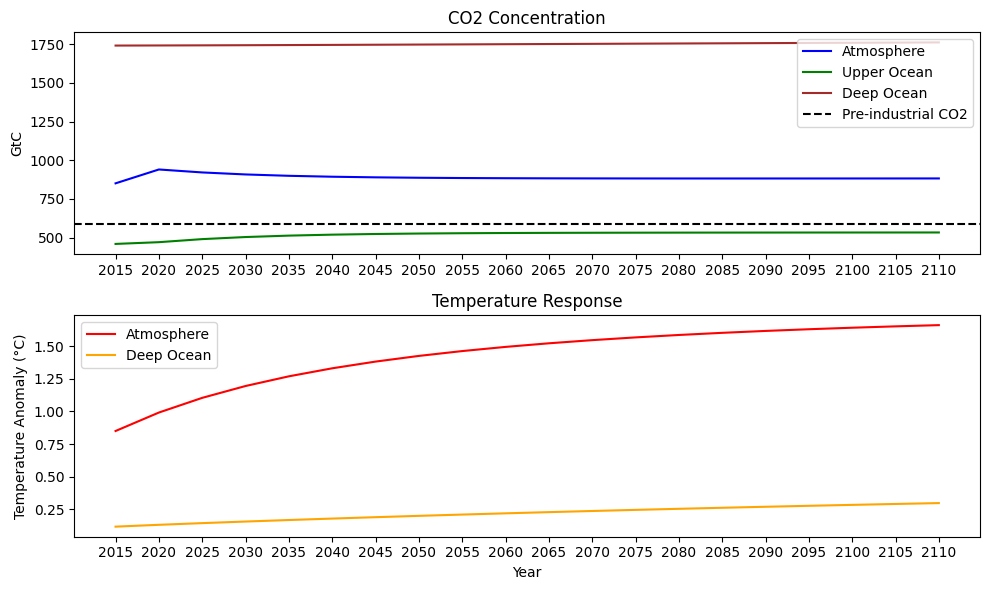

In [24]:
# Re-plot with adjusted x-axis ticks starting from 2015 and using 5-year intervals until 2100.

# Define the time axis (years from 2015)
years = np.arange(2015, 2015 + time_steps * 5, 5)

plt.figure(figsize=(10, 6))

# Carbon cycle plot
plt.subplot(2, 1, 1)
plt.plot(years, M_AT, label='Atmosphere', color='blue')
plt.plot(years, M_UP, label='Upper Ocean', color='green')
plt.plot(years, M_LO, label='Deep Ocean', color='brown')
plt.axhline(xM_AT_1750, color='black', linestyle='--', label='Pre-industrial CO2')
plt.title('CO2 Concentration')
plt.ylabel('GtC')
plt.legend()
plt.xticks(years)

# Temperature plot
plt.subplot(2, 1, 2)
plt.plot(years, T_AT, label='Atmosphere', color='red')
plt.plot(years, T_LO, label='Deep Ocean', color='orange')
plt.title('Temperature Response')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.xticks(years)

plt.tight_layout()
plt.savefig('basic_dice_simulation.pdf')

1.0
1.0055601831596335
1.0476702552735828
1.0827098093378387
1.1120898583720595
1.1369251703465184
1.1580866327474522
1.1762526726622111
1.1919533740142496
1.205605827389277
1.217541381001915
1.2280261852713046
1.2372764963093226
1.2454700195144015
1.2527543227244342
1.2592531055589045
1.26507091034316
1.2702967010275954
1.2750066182650575


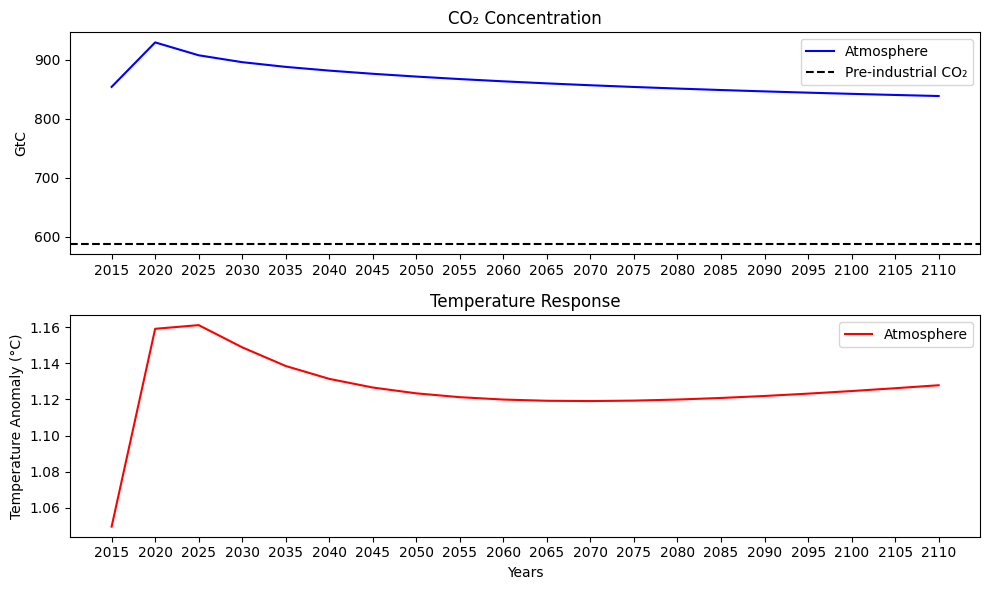

<Figure size 640x480 with 0 Axes>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

# Parameters for the FaIR model
xM_R1_0 = 127.159  # Initial carbon in reservoir 1 (atmosphere)
xM_R2_0 = 93.313   # Upper ocean
xM_R3_0 = 37.840   # Deep ocean
xM_R4_0 = 7.721    # Very deep ocean

a = np.array([0.217, 0.224, 0.282, 0.276])  # Carbon cycle partitioning coefficients
tau = np.array([1e7, 394.4, 36.54, 4.304])    # Time constants for carbon reservoirs

# Initial temperature-related parameters
xT_LO_0_FaIR = 0.324  # Initial lower ocean temp anomaly
xT_AT_0_FaIR = 1.243  # Initial atmospheric temp anomaly

# Temperature response parameters
xT_LO_tq = 0.324   # Lower ocean equilibration parameter
xT_UO_tq = 0.44    # Upper ocean equilibration parameter
xT_LO_rt = 236     # Lower ocean response timescale
xT_UO_rt = 4.1     # Upper ocean response timescale

# Constants for temperature model
xT_kappa = 3.6813  # Forcing at double CO₂ (W/m²)
C0 = 588           # Pre-industrial atmospheric carbon (GtC)

# Additional feedback parameters for alpha calculation
irf0 = 35           # Preindustrial equilibrium forcing
irC = 0.019         # Carbon feedback parameter
irT = 4.165         # Temperature feedback parameter

# Pulse emission (similar to previous experiment)
pulse_emission = 100  # GtC (CO₂ pulse)
time_steps = 20      # Time horizon in years

# Arrays to hold results
global_carbon_reservoirs = np.zeros((time_steps, 4))  # Four carbon reservoirs
T_UO = np.zeros(time_steps)               # Atmospheric temperature anomaly
T_LO = np.zeros(time_steps)               # Lower ocean temperature anomaly
alpha = np.ones(time_steps)               # Feedback parameter α
global_cumulative_emissions = np.zeros(time_steps)      # Cumulative emissions
global_emissions = np.zeros(time_steps)
global_temperature = np.zeros(time_steps) # Temperature
global_acc_pert_carb_stock = np.zeros(time_steps)
global_carbon_mass = np.zeros(time_steps)

# Initial values
conv = 1 #5/3.67
global_carbon_reservoirs[0] = [xM_R1_0, xM_R2_0, xM_R3_0, xM_R4_0]  # Initial carbon reservoir levels
M_atmosphere = np.zeros(time_steps)
T_UO[0] = 0.934127 
T_LO[0] = 0.11541
global_temperature[0] = T_UO[0] + T_LO[0]
global_cumulative_emissions[0] = (400 + 197) * conv
global_emissions[0] = pulse_emission * conv
global_acc_pert_carb_stock = global_acc_pert_carb_stock - sum(global_carbon_reservoirs[0])
alpha[0] = 1
global_carbon_mass[0] = C0 + sum(global_carbon_reservoirs[0])


# Function to compute α using temperature and cumulative carbon feedback
def compute_alpha(temp_anomaly, cumulative_emissions, prev_alpha):
    def DAE_(oneoveralpha):
        b = a * tau * (1 - np.exp(-100 * oneoveralpha / tau))
        return np.sum(b) - oneoveralpha * (
            irf0 + irC * cumulative_emissions + irT * temp_anomaly
        )
    
    # Solve the non-linear equation for α
    global_alpha = 1 / newton(DAE_, x0=1 / prev_alpha)
    
    # Ensure alpha stays in reasonable bounds
    if global_alpha < 0.01 or global_alpha > 100:
        raise ValueError(f"Alpha value {global_alpha} out of bounds.")
    
    return global_alpha


# Simulation loop
for t in range(1, time_steps):
    print(alpha[t-1])
    # Update carbon mass in each reservoir using FaIR model diffusion and alpha feedback
    global_carbon_reservoirs[t] = global_carbon_reservoirs[t-1] * np.exp(-5 / (tau * alpha[t-1])) + a * global_emissions[t-1] / 5 * conv * tau * alpha[t-1] * (1 - np.exp(-5 / (tau * alpha[t-1])))
        
    # Update cumulative emissions
    global_cumulative_emissions[t] = global_cumulative_emissions[t-1] + global_emissions[t-1] * conv
    
    global_acc_pert_carb_stock[t] = global_cumulative_emissions[t] - sum(global_carbon_reservoirs[t])
    global_carbon_mass[t] = C0 + sum((global_carbon_reservoirs[t]))
    
    forcing = xT_kappa * np.log(global_carbon_mass[t] / C0) / np.log(2)
    
    # Update global temperature dynamics (atmospheric and lower ocean)
    T_UO[t] = T_UO[t-1] * np.exp(-5 / xT_UO_rt) + xT_UO_tq * forcing * (1 - np.exp(-5 / xT_UO_rt))
    T_LO[t] = T_LO[t-1] * np.exp(-5 / xT_LO_rt) + xT_LO_tq * forcing * (1 - np.exp(-5 / xT_LO_rt))
    
    # Compute new alpha (feedback parameter) based on temperature and cumulative emissions
    alpha[t] = compute_alpha(T_AT[t], global_cumulative_emissions[t], alpha[t-1])

# Plotting the results
plt.figure(figsize=(10, 6))

# Carbon cycle plot
plt.subplot(2, 1, 1)

# Define the time axis (years from 2015)
years = np.arange(2015, 2015 + time_steps * 5, 5)

plt.plot(years, global_carbon_mass, label='Atmosphere', color='blue')
plt.axhline(C0, color='black', linestyle='--', label='Pre-industrial CO₂')
plt.title('CO₂ Concentration')
plt.ylabel('GtC')
plt.xticks(years)
plt.legend()

# Temperature plot
plt.subplot(2, 1, 2)
plt.plot(years, T_UO+T_LO, label='Atmosphere', color='red')
plt.title('Temperature Response')
plt.xlabel('Years')
plt.ylabel('Temperature Anomaly (°C)')
plt.xticks(years)
plt.legend()

plt.tight_layout()
plt.savefig('fair_simulation.pdf')
plt.show()

# save the plot